In [ ]:
!pip3 install datasets stanza sinkaf TurkishStemmer transformers JPype1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.8/493.8 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
!apt-get install -y openjdk-11-jdk-headless -qq > /dev/null

In [ ]:
from datasets import load_dataset

dataset = load_dataset("Overfit-GM/turkish-toxic-language")

dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

turkish_toxic_language.csv:   0%|          | 0.00/18.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/77800 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'target', 'source', 'is_toxic'],
        num_rows: 77800
    })
})

In [ ]:
# ignore unnecessary warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd

# numpy and pandas for process and analyze
import pandas as pd
import numpy as np

# nltk for stopwords
from nltk.corpus import stopwords
import nltk

#re for clean special char
import re

# stanza for NLP preprocessing
!pip install stanza
import stanza

import torch.nn as nn

# sklearn libraries for models and evaulation metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

# transformers libraries for NLP model training and evaluation
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, BertModel, DataCollatorWithPadding

# pytorch library for data handling, model training, and loss computation
from torch.utils.data import Dataset, DataLoader
import torch
from torch.nn import CrossEntropyLoss

# matpilotlib and seaborn libraries for visualize
import matplotlib.pyplot as plt
import seaborn as sns

# progress bar for data processing
from tqdm import tqdm

# Turkish Stemmer
from TurkishStemmer import TurkishStemmer

from sinkaf import Sinkaf

from google.colab import drive
drive.mount('/content/drive')

# jpype
from typing import List
from jpype import JClass, JString, getDefaultJVMPath, shutdownJVM, startJVM, java, isJVMStarted

# install and download stanza's turkish model
stanza.download("tr", verbose=False)
print("Stanza Turkish model downloaded!")

nlp = stanza.Pipeline("tr", use_gpu=True)

print("Libraries and NLTK datasets loaded!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Stanza Turkish model downloaded!
Libraries and NLTK datasets loaded!


In [ ]:
zemberek_jar_path = "/content/drive/My Drive/zemberek.jar"

if not isJVMStarted():
    startJVM(getDefaultJVMPath(), f"-Djava.class.path={zemberek_jar_path}", "-ea")

TurkishMorphology = JClass('zemberek.morphology.TurkishMorphology')
TurkishSpellChecker = JClass('zemberek.normalization.TurkishSpellChecker')

morphology = TurkishMorphology.createWithDefaults()
spell_checker = TurkishSpellChecker(morphology)

dataset = load_dataset("Overfit-GM/turkish-toxic-language")
train = dataset['train'].to_pandas()

def correct_spelling(text):
    words = text.split()
    corrected_words = []
    for word in words:
        if spell_checker.check(word):
            corrected_words.append(str(word))
        else:
            suggestions = spell_checker.suggestForWord(word)
            if suggestions:
                corrected_words.append(str(suggestions[0]))
            else:
                corrected_words.append(str(word))
    return " ".join(corrected_words)

tqdm.pandas()
train['corrected_text'] = train['text'].progress_apply(correct_spelling)

train.to_csv("/content/drive/My Drive/corrected_dataset.csv", index=False)

shutdownJVM()

train

 20%|█▉        | 15234/77800 [00:29<02:02, 509.59it/s]


KeyboardInterrupt: 

In [ ]:
turkish_characters = "ğüşıöçĞÜŞİÖÇ"
train = train[train['corrected_text'].str.contains(f"[{turkish_characters}]", na=False)]
train

,text,target,source,is_toxic,corrected_text
0,Phil Spector bir lanet katil olduğunu Biliyors...,INSULT,jigsaw,1,Phil Spector bir lanet katil olduğunu Biliyors...
1,Lan siktirin gidin AMK pozitif sik kafaları Ül...,PROFANITY,told,1,Lan siktirin gidin AMA pozitif sik kafaları Ül...
2,2pac Olmak İstiyorum Ja Rule bir Tupac Shakur ...,OTHER,jigsaw,0,2pac Olmak İstiyorum Da Rule bir Tupac Shakur ...
3,Ne yapılması gerekiyor Aradan sonra bu sayfaya...,OTHER,jigsaw,0,Ne yapılması gerekiyor Aradan sonra bu sayfaya...
4,Kabul Dream Chaser programı ile ilgili olmayan...,OTHER,jigsaw,0,Kabul Dream Chase programı ile ilgili olmayan ...
...,...,...,...,...,...
77795,İsmi kısaltmak için her kutu kendi başına bir ...,OTHER,jigsaw,0,İsmi kısaltmak için her kutu kendi başına bir ...
77796,ecek acak 31 marta kadar incelenir gorusulur d...,OTHER,told,0,Emek ancak 31 marta kadar incelenir gorusulur ...
77797,Oh adamım Sen sadece yumuşak bir ineğin Birkaç...,INSULT,jigsaw,1,Oh adamım Sen sadece yumuşak bir ineğin Birkaç...
77798,Bu zayıf siteyi temizleyeceğim hyyuyuyuyuyuyuy...,INSULT,jigsaw,1,Bu zayıf siteyi temizleyeceğim hyyuyuyuyuyuyuy...


In [ ]:
# sinkaf profanity filter
profanity_filter = Sinkaf(model = "bert_pre")

nltk.download("stopwords")
stop_words = set(stopwords.words("turkish"))

# function: remove special char
def remove_special_characters(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'[\U00010000-\U0010FFFF]', '', text)
    return text

stemmer = TurkishStemmer()

# function: manual stemming (cutting to 5 characters if longer)
def manual_stem(text):
    return text[:5] if len(text) > 5 else text

# preprocessing function
def preprocess_text_stanza_with_sinkaf(text):
    text = remove_special_characters(text.lower())

    doc = nlp(text)
    lemmatized_tokens = []

    for sentence in doc.sentences:
        for word in sentence.words:
            if word.text.isalpha() and word.text not in stop_words:
                if word.lemma is not None:
                    lemmatized_tokens.append(word.lemma)
                else:
                    profanity_score = profanity_filter.tahminlik([word.text])[0]
                    if profanity_score > 0.9:
                        lemmatized_tokens.append(word.text)
                    else:
                        stemmed_word = stemmer.stem(word.text)
                        if len(stemmed_word) == len(word.text):
                            stemmed_word = manual_stem(word.text)
                        lemmatized_tokens.append(stemmed_word)

    return " ".join(lemmatized_tokens)

# Veriyi işleme
tqdm.pandas()

train["cleaned_text"] = train["corrected_text"].progress_apply(preprocess_text_stanza_with_sinkaf)

train

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 0.24.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MLPClassifier from version 0.24.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Tek seferlik BERT kurulumu gerekebilmektedir.



tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/386 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/740M [00:00<?, ?B/s]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
100%|██████████| 74809/74809 [2:45:37<00:00,  7.53it/s]
<ipython-input-7-e82f61d8a8af>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["cleaned_text"] = train["corrected_text"].progress_apply(preprocess_text_stanza_with_sinkaf)


,text,target,source,is_toxic,corrected_text,cleaned_text
0,Phil Spector bir lanet katil olduğunu Biliyors...,INSULT,jigsaw,1,Phil Spector bir lanet katil olduğunu Biliyors...,phil spector bir lanet katil ol bil ben tıpkı ...
1,Lan siktirin gidin AMK pozitif sik kafaları Ül...,PROFANITY,told,1,Lan siktirin gidin AMA pozitif sik kafaları Ül...,la sik git pozitif sik kafa ülke ana dikil mil...
2,2pac Olmak İstiyorum Ja Rule bir Tupac Shakur ...,OTHER,jigsaw,0,2pac Olmak İstiyorum Da Rule bir Tupac Shakur ...,ol iste rule bir tupac shakur ol iste çoğu zam...
3,Ne yapılması gerekiyor Aradan sonra bu sayfaya...,OTHER,jigsaw,0,Ne yapılması gerekiyor Aradan sonra bu sayfaya...,yap gerek ara sonra sayfa bak gör kölelik din ...
4,Kabul Dream Chaser programı ile ilgili olmayan...,OTHER,jigsaw,0,Kabul Dream Chase programı ile ilgili olmayan ...,kabul dream chase program ilgili ol çok kal m
...,...,...,...,...,...,...
77795,İsmi kısaltmak için her kutu kendi başına bir ...,OTHER,jigsaw,0,İsmi kısaltmak için her kutu kendi başına bir ...,isim kısal kut kendi baş bir sayfa ol i zaten ...
77796,ecek acak 31 marta kadar incelenir gorusulur d...,OTHER,told,0,Emek ancak 31 marta kadar incelenir gorusulur ...,emek ancak marta kadar incele goru dusun hazin...
77797,Oh adamım Sen sadece yumuşak bir ineğin Birkaç...,INSULT,jigsaw,1,Oh adamım Sen sadece yumuşak bir ineğin Birkaç...,oh adam sen sadece yumuşak bir inek saniye iç ...
77798,Bu zayıf siteyi temizleyeceğim hyyuyuyuyuyuyuy...,INSULT,jigsaw,1,Bu zayıf siteyi temizleyeceğim hyyuyuyuyuyuyuy...,zayıf site temizle


In [ ]:
output_file = "/content/drive/My Drive/cleaned_dataset.csv"

train.to_csv(output_file, index=False, encoding="utf-8")

print(f"Cleaned dataset saved to Google Drive at {output_file}")

Cleaned dataset saved to Google Drive at /content/drive/My Drive/cleaned_dataset.csv


In [123]:
input_file = "/content/drive/My Drive/cleaned_dataset.csv"

train = pd.read_csv(input_file, encoding="utf-8")

train

,text,target,source,is_toxic,corrected_text,cleaned_text
0,Phil Spector bir lanet katil olduğunu Biliyors...,INSULT,jigsaw,1,Phil Spector bir lanet katil olduğunu Biliyors...,phil spector bir lanet katil ol bil ben tıpkı ...
1,Lan siktirin gidin AMK pozitif sik kafaları Ül...,PROFANITY,told,1,Lan siktirin gidin AMA pozitif sik kafaları Ül...,la sik git pozitif sik kafa ülke ana dikil mil...
2,2pac Olmak İstiyorum Ja Rule bir Tupac Shakur ...,OTHER,jigsaw,0,2pac Olmak İstiyorum Da Rule bir Tupac Shakur ...,ol iste rule bir tupac shakur ol iste çoğu zam...
3,Ne yapılması gerekiyor Aradan sonra bu sayfaya...,OTHER,jigsaw,0,Ne yapılması gerekiyor Aradan sonra bu sayfaya...,yap gerek ara sonra sayfa bak gör kölelik din ...
4,Kabul Dream Chaser programı ile ilgili olmayan...,OTHER,jigsaw,0,Kabul Dream Chase programı ile ilgili olmayan ...,kabul dream chase program ilgili ol çok kal m
...,...,...,...,...,...,...
74804,İsmi kısaltmak için her kutu kendi başına bir ...,OTHER,jigsaw,0,İsmi kısaltmak için her kutu kendi başına bir ...,isim kısal kut kendi baş bir sayfa ol i zaten ...
74805,ecek acak 31 marta kadar incelenir gorusulur d...,OTHER,told,0,Emek ancak 31 marta kadar incelenir gorusulur ...,emek ancak marta kadar incele goru dusun hazin...
74806,Oh adamım Sen sadece yumuşak bir ineğin Birkaç...,INSULT,jigsaw,1,Oh adamım Sen sadece yumuşak bir ineğin Birkaç...,oh adam sen sadece yumuşak bir inek saniye iç ...
74807,Bu zayıf siteyi temizleyeceğim hyyuyuyuyuyuyuy...,INSULT,jigsaw,1,Bu zayıf siteyi temizleyeceğim hyyuyuyuyuyuyuy...,zayıf site temizle


In [124]:
train = train[~train['target'].isin(['RACIST', 'SEXIST'])].reset_index(drop=True)

train['target'] = train['target'].replace({'INSULT': 'OFFENSIVE', 'PROFANITY': 'OFFENSIVE'})

print(train['target'].value_counts())
train

target
OTHER        37004
OFFENSIVE    27034
Name: count, dtype: int64


,text,target,source,is_toxic,corrected_text,cleaned_text
0,Phil Spector bir lanet katil olduğunu Biliyors...,OFFENSIVE,jigsaw,1,Phil Spector bir lanet katil olduğunu Biliyors...,phil spector bir lanet katil ol bil ben tıpkı ...
1,Lan siktirin gidin AMK pozitif sik kafaları Ül...,OFFENSIVE,told,1,Lan siktirin gidin AMA pozitif sik kafaları Ül...,la sik git pozitif sik kafa ülke ana dikil mil...
2,2pac Olmak İstiyorum Ja Rule bir Tupac Shakur ...,OTHER,jigsaw,0,2pac Olmak İstiyorum Da Rule bir Tupac Shakur ...,ol iste rule bir tupac shakur ol iste çoğu zam...
3,Ne yapılması gerekiyor Aradan sonra bu sayfaya...,OTHER,jigsaw,0,Ne yapılması gerekiyor Aradan sonra bu sayfaya...,yap gerek ara sonra sayfa bak gör kölelik din ...
4,Kabul Dream Chaser programı ile ilgili olmayan...,OTHER,jigsaw,0,Kabul Dream Chase programı ile ilgili olmayan ...,kabul dream chase program ilgili ol çok kal m
...,...,...,...,...,...,...
64033,İsmi kısaltmak için her kutu kendi başına bir ...,OTHER,jigsaw,0,İsmi kısaltmak için her kutu kendi başına bir ...,isim kısal kut kendi baş bir sayfa ol i zaten ...
64034,ecek acak 31 marta kadar incelenir gorusulur d...,OTHER,told,0,Emek ancak 31 marta kadar incelenir gorusulur ...,emek ancak marta kadar incele goru dusun hazin...
64035,Oh adamım Sen sadece yumuşak bir ineğin Birkaç...,OFFENSIVE,jigsaw,1,Oh adamım Sen sadece yumuşak bir ineğin Birkaç...,oh adam sen sadece yumuşak bir inek saniye iç ...
64036,Bu zayıf siteyi temizleyeceğim hyyuyuyuyuyuyuy...,OFFENSIVE,jigsaw,1,Bu zayıf siteyi temizleyeceğim hyyuyuyuyuyuyuy...,zayıf site temizle


In [125]:
def clean_corrected_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r"@\w+", '', text)
    text = re.sub(r"[^\w\s.,!?-]", '', text)
    text = re.sub(r"\s+", ' ', text).strip()
    return text

train['cleaned_corrected_text'] = train['corrected_text'].apply(clean_corrected_text)


print(train['target'].value_counts())
train

target
OTHER        37004
OFFENSIVE    27034
Name: count, dtype: int64


,text,target,source,is_toxic,corrected_text,cleaned_text,cleaned_corrected_text
0,Phil Spector bir lanet katil olduğunu Biliyors...,OFFENSIVE,jigsaw,1,Phil Spector bir lanet katil olduğunu Biliyors...,phil spector bir lanet katil ol bil ben tıpkı ...,phil spector bir lanet katil olduğunu biliyors...
1,Lan siktirin gidin AMK pozitif sik kafaları Ül...,OFFENSIVE,told,1,Lan siktirin gidin AMA pozitif sik kafaları Ül...,la sik git pozitif sik kafa ülke ana dikil mil...,lan siktirin gidin ama pozitif sik kafaları ül...
2,2pac Olmak İstiyorum Ja Rule bir Tupac Shakur ...,OTHER,jigsaw,0,2pac Olmak İstiyorum Da Rule bir Tupac Shakur ...,ol iste rule bir tupac shakur ol iste çoğu zam...,2pac olmak istiyorum da rule bir tupac shakur ...
3,Ne yapılması gerekiyor Aradan sonra bu sayfaya...,OTHER,jigsaw,0,Ne yapılması gerekiyor Aradan sonra bu sayfaya...,yap gerek ara sonra sayfa bak gör kölelik din ...,ne yapılması gerekiyor aradan sonra bu sayfaya...
4,Kabul Dream Chaser programı ile ilgili olmayan...,OTHER,jigsaw,0,Kabul Dream Chase programı ile ilgili olmayan ...,kabul dream chase program ilgili ol çok kal m,kabul dream chase programı ile ilgili olmayan ...
...,...,...,...,...,...,...,...
64033,İsmi kısaltmak için her kutu kendi başına bir ...,OTHER,jigsaw,0,İsmi kısaltmak için her kutu kendi başına bir ...,isim kısal kut kendi baş bir sayfa ol i zaten ...,ismi kısaltmak için her kutu kendi başına bir ...
64034,ecek acak 31 marta kadar incelenir gorusulur d...,OTHER,told,0,Emek ancak 31 marta kadar incelenir gorusulur ...,emek ancak marta kadar incele goru dusun hazin...,emek ancak 31 marta kadar incelenir gorusulur ...
64035,Oh adamım Sen sadece yumuşak bir ineğin Birkaç...,OFFENSIVE,jigsaw,1,Oh adamım Sen sadece yumuşak bir ineğin Birkaç...,oh adam sen sadece yumuşak bir inek saniye iç ...,oh adamım sen sadece yumuşak bir ineğin birkaç...
64036,Bu zayıf siteyi temizleyeceğim hyyuyuyuyuyuyuy...,OFFENSIVE,jigsaw,1,Bu zayıf siteyi temizleyeceğim hyyuyuyuyuyuyuy...,zayıf site temizle,bu zayıf siteyi temizleyeceğim hyyuyuyuyuyuyuy...


In [126]:
from imblearn.under_sampling import RandomUnderSampler

X = train[['cleaned_text','cleaned_corrected_text']]
y = train['is_toxic']

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

print("Örnek sayıları:")
print(y_resampled.value_counts())

undersampled_data = pd.concat([X_resampled, y_resampled], axis=1)

undersampled_data.to_csv("undersampled_dataset.csv", index=False)

undersampled_data

Örnek sayıları:
is_toxic
0    27034
1    27034
Name: count, dtype: int64


,cleaned_text,cleaned_corrected_text,is_toxic
62409,ilmek ilmek dokuduk çaba bir birliktelik inşaa...,ilmek ilmek dokuduk çabamızla bir birliktelik ...,0
28337,yol git iç sıkıntı var akbaba arkadaş öl saat ...,yola gidicem diye içimde bu sıkıntı vardı akba...,0
36018,kesin kar sadece bir valiz gel yurdum yet sefe...,çok kesin kararlıyım sadece bir valizle gelece...,0
38284,dünya tur yapan ev gel boşluk düş mi ben bakka...,bu dünya turu yapanlar evlerine gelince boşluğ...,0
26765,ret yeni wikipe sayfa,ret yeni wikipedia sayfası,0
...,...,...,...
64028,düşün sor küfür et ben anlık bildirim yol gün ...,ne düşünüyorsun diye soruyorsun ya küfür ediyo...,1
64032,yor beyincik bu yaz algı yoksun embesil sen,çok yordun mu beyinciğini bunu yazmak için alg...,1
64035,oh adam sen sadece yumuşak bir inek saniye iç ...,oh adamım sen sadece yumuşak bir ineğin birkaç...,1
64036,zayıf site temizle,bu zayıf siteyi temizleyeceğim hyyuyuyuyuyuyuy...,1


In [127]:
kelimeler = ["kanka", "lan", "knk", "bro", "la", "birader", "kanki"]

def kelime_cikartici(metin):
    for kelime in kelimeler:
        metin = metin.replace(kelime, "")
    return metin.strip()

undersampled_data["cleaned_corrected_text"] = undersampled_data["cleaned_corrected_text"].apply(kelime_cikartici)

undersampled_data

,cleaned_text,cleaned_corrected_text,is_toxic
62409,ilmek ilmek dokuduk çaba bir birliktelik inşaa...,ilmek ilmek dokuduk çabamız bir birliktelik in...,0
28337,yol git iç sıkıntı var akbaba arkadaş öl saat ...,yo gidicem diye içimde bu sıkıntı vardı akbaba...,0
36018,kesin kar sadece bir valiz gel yurdum yet sefe...,çok kesin kararlıyım sadece bir valizle gelece...,0
38284,dünya tur yapan ev gel boşluk düş mi ben bakka...,bu dünya turu yapanr evlerine gelince boşluğa ...,0
26765,ret yeni wikipe sayfa,ret yeni wikipedia sayfası,0
...,...,...,...
64028,düşün sor küfür et ben anlık bildirim yol gün ...,ne düşünüyorsun diye soruyorsun ya küfür ediyo...,1
64032,yor beyincik bu yaz algı yoksun embesil sen,çok yordun mu beyinciğini bunu yazmak için alg...,1
64035,oh adam sen sadece yumuşak bir inek saniye iç ...,oh adamım sen sadece yumuşak bir ineğin birkaç...,1
64036,zayıf site temizle,bu zayıf siteyi temizleyeceğim hyyuyuyuyuyuyuy...,1


In [128]:
data = undersampled_data

X_train, X_test, y_train, y_test = train_test_split(
    data['cleaned_corrected_text'], data['is_toxic'], test_size=0.2, random_state=42
)

model_name = "dbmdz/bert-base-turkish-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

class ToxicityDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
        }

train_dataset = ToxicityDataset(X_train, y_train, tokenizer)
test_dataset = ToxicityDataset(X_test, y_test, tokenizer)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)

trainer.train()

model.save_pretrained("./turkish_toxic_language_detection_model")
tokenizer.save_pretrained("./turkish_toxic_language_detection_model")

print("train finished")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.134400,0.123694
2,0.062600,0.174339
3,0.001600,0.202964


train finished


In [136]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

def test_model(test_sentences, model_path="./turkish_toxic_language_detection_model"):
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)

    model.eval()

    predictions = []

    with torch.no_grad():
        for sentence in test_sentences:
            encoding = tokenizer(
                sentence,
                truncation=True,
                padding="max_length",
                max_length=128,
                return_tensors="pt",
            )

            input_ids = encoding["input_ids"]
            attention_mask = encoding["attention_mask"]

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            predicted_label = torch.argmax(logits, dim=1).item()
            predictions.append(predicted_label)

    return predictions

test_sentences = [
    "zeki insanlar kitap okumuştur",
    "suratlarına tükürsek zerre utanmazlar.. kk  pkkcıydı demi bu ... gargameline göre.. şu çağrıyı kk yapsaydı hapse atardı bu o....ları ... ",
    "onemli oranda aliyorda, siaysetciler kendi atadıklari gudumlu hakimin yerine adil bir yapay zeka istemez",
    "Bu arada sozlesmeli personelin kadroya geçmesini tüm sendikalar destekler ve başarı diye anlatirlar"
]

predictions = test_model(test_sentences)

for sentence, prediction in zip(test_sentences, predictions):
    print(f"Cümle: {sentence} -> Tahmin: {'Toksik' if prediction == 1 else 'Toksik Değil'}")

Cümle: zeki insanlar kitap okumuştur -> Tahmin: Toksik Değil
Cümle: suratlarına tükürsek zerre utanmazlar.. kk  pkkcıydı demi bu ... gargameline göre.. şu çağrıyı kk yapsaydı hapse atardı bu o....ları ...  -> Tahmin: Toksik
Cümle: onemli oranda aliyorda, siaysetciler kendi atadıklari gudumlu hakimin yerine adil bir yapay zeka istemez -> Tahmin: Toksik Değil
Cümle: Bu arada sozlesmeli personelin kadroya geçmesini tüm sendikalar destekler ve başarı diye anlatirlar -> Tahmin: Toksik Değil


Classification Report:
              precision    recall  f1-score   support

   Non-Toxic       0.96      0.95      0.96      5400
       Toxic       0.95      0.96      0.96      5414

    accuracy                           0.96     10814
   macro avg       0.96      0.96      0.96     10814
weighted avg       0.96      0.96      0.96     10814



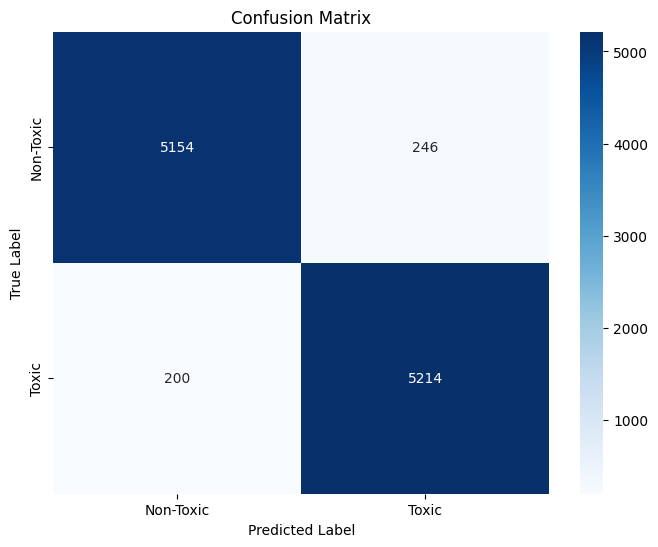

In [137]:
# classification report


# generate predictions
predictions = trainer.predict(test_dataset)
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1)

# performance metrics
print("Classification Report:")
print(classification_report(y_test, predicted_labels, target_names=["Non-Toxic", "Toxic"]))

# confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)

# visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Toxic", "Toxic"], yticklabels=["Non-Toxic", "Toxic"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()